# Additions to EGO model calculation (august2018, version 1.3.17)
Several features were added to EGO application.
* loop calculation statistics in form of file output (-out_loops_stats) and console output. Statistics include aggregated information about prices, spread percent, adjusted spread percent, line flow adjustment and real line flow changes. This data can be used to assess model performance and calculation progress.
* new spread percent adjustment mode (-spread_percent_adjustment smooth), that maps any spread percent value into range (-1,1) with continuous smooth monotonic function.

## Original spread percent calculation and adjustment
Historically spread percent and spread percent adjusted values were calculated using the following formula:
```
spread_pct = (price_to-price_from)/price_to
```
 'to' and 'from' hubs are determined by line description and not actual line flow, which can lead to quite high absolute spread percent values if price spread points in opposite direction to line description and price difference is considerably greater than the cheapest price. Unadjusted high spread percent value could generate high line flow changes and hamper model convergence.
To fix this issue there is a "spread percent adjustment" step, in which we calculate adjusted spread percent that will substitute high absolute spread percent values with smaller constants.
```
 if spread_pct <= -1
    spread_pct_adjusted = -0.25 
 else if spread_pct >= 1
    spread_pct_adjusted = 0.5
 else spread_pct_adjusted = spread_pct
```
While this step helps algorithm convergence, it sometimes can prevent algorithm from reaching optimum value. Consider the situation when one hub has two lines with considerably different spread percent values, spread_percent1 > spread_percent2, but for the adjusted spread percent values the relation is the opposite (as one of the values was changed to a smaller constant) and spread_percent_adjusted1 < spread_percent_adjusted2. In this case line that has higher price difference (spread percent) will consistently receive less flow than line with lower price difference, so that imbalance could never be solved. This can happen in scenarios with limited production (especially when production does not match demand).
## Other spread adjustment options
There are two alternative options for spread percent calculation and adjustment.
Their performance can be better in scenarios with high price differences, but can be worse in 'usual' scenarios when there is no deficit present and prices values are similar across hubs.
### "Divide by high price" spread percent calculation
In this case spread percent is calculated with the formula:
```
spread_pct = (price_to-price_from)/max(price_to,price_from)
```
The result value will always lie within (-1,1) range, given that price is always >0.
This option is turned by command line parameter "-spread_pct_divide_by_highest_price". This option was introduced long ago, but during brief testing it did not show better convergence or better final results in calculation (in fact comparison of the different algorithm was not straightforward as there were no simply accessible metrics of perfrormance).
### Smooth spread percent adjustment
We can adjust spread percent value by applying continuous, smooth and monotonic function that maps any spread percent value to range of (-1,1). There are a lot of such functions: sigmoid and others.
I choose algebraic function 
```
y = x / sqrt(1+ x*x)
```
To use this adjustment function you need to use '-spread_pct_adjustment' command line option with value 'smooth'.
```
ego ... -spread_pct_adjustment smooth
```
In the next sections we will compare the functions and test results.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def original_adjustment(x):
    xn = np.copy(x)
    xn[x<=-1] = -0.25
    xn[x>=1] = 0.5    
    return xn

def smooth_adjustment(x):
    #  smooth adjustment function
    return x / np.sqrt(1+ x**2)

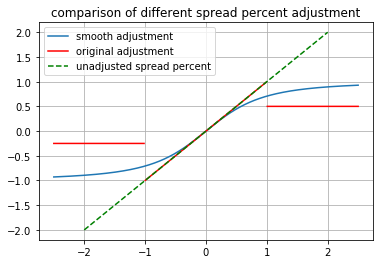

In [3]:
x_plot_range = 2.5

x = np.linspace(-x_plot_range, x_plot_range, 500)
y_original = original_adjustment(x)
# prevent from joining discontinuous parts
y_original[np.append(np.abs(np.diff(y_original)) >= 0.1,[False])] = np.nan
y_smooth = smooth_adjustment(x)

plt.plot(x, y_smooth, label = 'smooth adjustment')
plt.plot(x, y_original, color = 'r', label = 'original adjustment')
x_unadjusted = np.linspace(-2, 2, 10)
plt.plot(x_unadjusted, x_unadjusted, 'g--', label = 'unadjusted spread percent')

plt.grid()
plt.legend()
plt.title('comparison of different spread percent adjustment')
plt.show()

For instance, if we have 2 energy lines (A and B) with spread percent values = -1.5 and -0.6, then after 'original' spread percent adjustment the adjusted spread percent values will be -0.25 for A and -0.6 for B. This will result line flow adjustment of line A to be lower than of line B, despite the fact that price difference is greater for line A.

## Loops statistics output
EGO lacked metrics of model performance that could tell if we reached good calculation result or how well calculation advanced with each loop iteration. We can consider average price or average price range across hubs as one of such possible metrics. If, as a result of calculation, average price goes down and average price range decreases, then we can tell that model is performing good.
Now there is a new output file for loop calculation metrics.
The file contains loop calculation metrics that can be used to monitor model convergence and performance. So far file contains metrics for following values: prices, spread percent, adjusted spread percent, flow adjustment and flow change. For every source value three different metrics are calculated:
* mean (overall average across all hubs/lines and history)
* average range (value range across all hubs or lines is calculated for every history point, then mean for these result values is calculated)
* average standard deviation (standard deviation for a given value is calculated for every history point, then mean for these result values is calculated)

Loop statistics file also contains information about loop number and loop adjustment coefficient (that is used to calculate line flow adjustment). The file contains N+1 lines, where N = number of loop iterations taken. The first line (with loop field = 0) corresponds to initial adjustment and price match that is done before any optimization iteration.

In [4]:
def compare_plot(dataframes, dataframe_names, fields, 
                 titles=None, start_pos=0, grid = False):
    # plots comparison graphs for fieds of list of dataframes
    # there will be separate figure for every field
    numplots = len(fields)
    for field_index, field in enumerate(fields):
        plt.figure(field_index)
        title = titles[field_index] if titles else field
        plt.title(title)
        for frame_index, frame in enumerate(dataframes):
            plt.plot(frame[field][start_pos:], label=dataframe_names[frame_index])
        plt.legend()
        plt.grid(grid)
        plt.show()

In [5]:
# here is statistics for 'far future' forecast
stats_orig = pd.read_csv('stats_orig.csv')
stats_smooth = pd.read_csv('stats_smooth.csv')
# * divide by highest price adjusment 
#   spread_pct = (price_to-price_from)/max(price_to,price_from)
stats_hpr = pd.read_csv('stats_hpr.csv')
dataframes = [stats_orig, stats_smooth, stats_hpr]
dataframe_names = ['original', 'smooth', 'divide by highest price']

Let's compare suggested prices metrics for 'far future' forecast, where there are a lot of cases with energy production deficit.

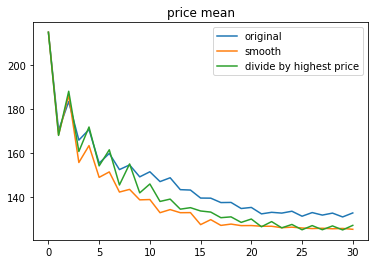

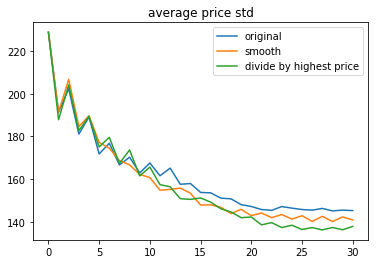

In [6]:
compare_plot(dataframes, dataframe_names, 
             ['price_mean','price_avg_std'],
             ['price mean','average price std'],
            )

Now let's look at the plot part that correspond to iterations from 10 to 30.

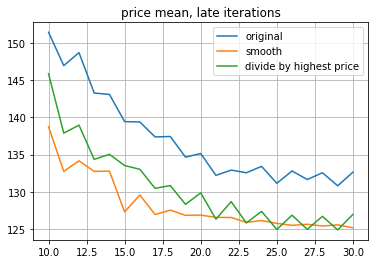

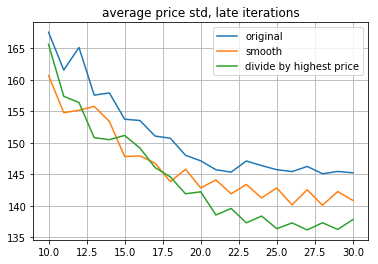

In [7]:
compare_plot(dataframes, dataframe_names, 
             ['price_mean','price_avg_std'],
             ['price mean, late iterations','average price std, late iterations'],
             start_pos = 10, grid = True
            )

In previous price plot we can see that model with original spread percent adjustment performs not so good as others - it results in higher prices on average.

In [8]:
nloops = len(stats_orig) -1
print('''average price after %d iterations
original: %f 
smooth: %f
divide by highest price: %f''' % (nloops, 
                                  stats_orig.price_mean[nloops], 
                                  stats_smooth.price_mean[nloops], 
                                  stats_hpr.price_mean[nloops]))

average price after 30 iterations
original: 132.630200 
smooth: 125.167000
divide by highest price: 126.959400


In input data there is a case with quite low production price (min_run_cost = 0.001, which results for some dates and hours really huge spread percent values).
Let's see mean metrics for spread percent value.

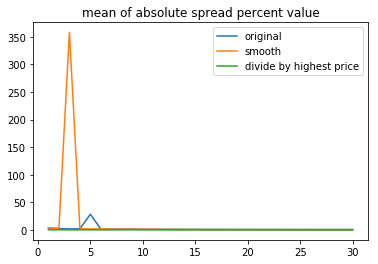

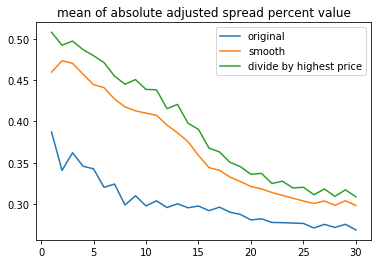

In [9]:
compare_plot(dataframes, 
             dataframe_names, 
             ['abs_spread_pct_mean', 
              'abs_spread_pct_adj_mean'],
             ['mean of absolute spread percent value', 
              'mean of absolute adjusted spread percent value'],             
             start_pos=1)

Part of the graph for spread percent metrics in loop iterations from 7 to 30.

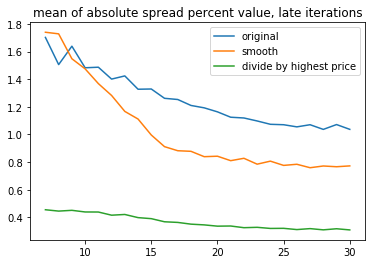

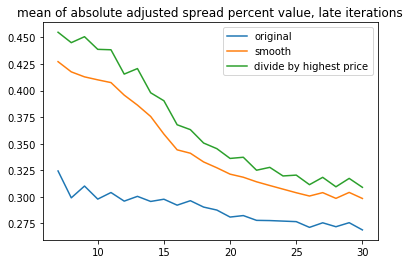

In [10]:
# same spread percents graphs but starting from loop 7
compare_plot(dataframes, 
    dataframe_names, 
    ['abs_spread_pct_mean', 'abs_spread_pct_adj_mean'],
    ['mean of absolute spread percent value, late iterations', 
     'mean of absolute adjusted spread percent value, late iterations'],             
    start_pos=7)

Let's have a look at line flow adjustment metrics.

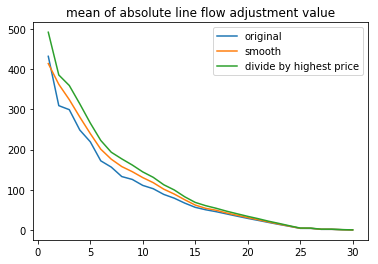

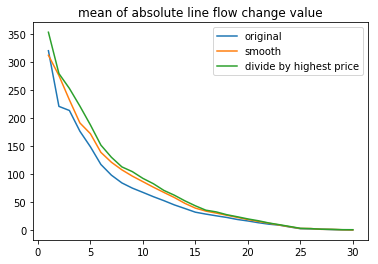

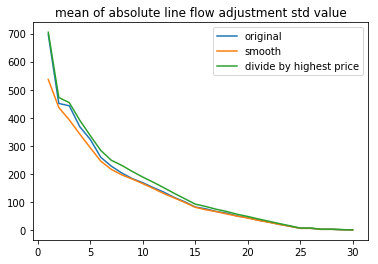

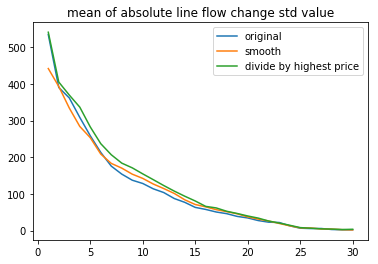

In [11]:
compare_plot(dataframes, 
             dataframe_names, 
             ['abs_line_flow_adj_mean', 'abs_line_flow_change_mean', 
              'abs_line_flow_adj_avg_std', 'abs_line_flow_change_avg_std'],
             ['mean of absolute line flow adjustment value', 'mean of absolute line flow change value',
              'mean of absolute line flow adjustment std value', 'mean of absolute line flow change std value'],                          
              start_pos=1)

When observing line flow adjustment and line flow change dynamics we should keep in mind that the values go lower not only because lower spread percent values but also because of smaller loop adjustment coefficient. 
Reaching some limiting condition (line or hub production capacity) can also have impact on smaller line flow changes.

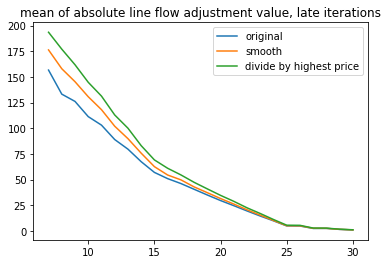

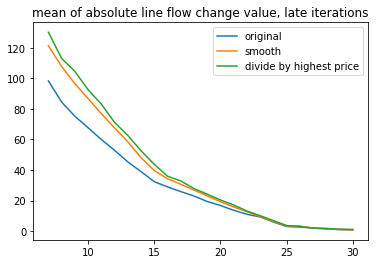

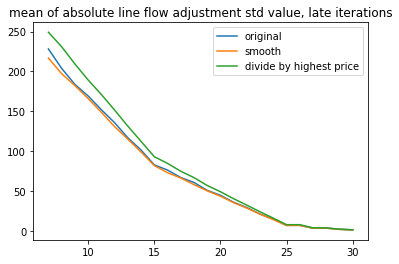

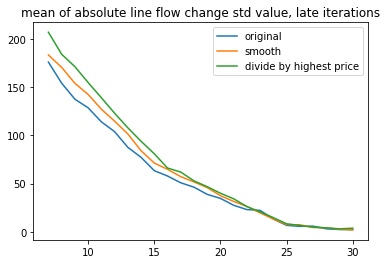

In [12]:
compare_plot(dataframes, 
             dataframe_names, 
             ['abs_line_flow_adj_mean',
              'abs_line_flow_change_mean', 
              'abs_line_flow_adj_avg_std', 
              'abs_line_flow_change_avg_std'],
             ['mean of absolute line flow adjustment value, late iterations', 
              'mean of absolute line flow change value, late iterations',
              'mean of absolute line flow adjustment std value, late iterations', 
              'mean of absolute line flow change std value, late iterations'],                                       
             start_pos=7)

## Conclusions
### Loops statistics output can be used to monitor model performance
New loops statistics output file contains loop calculation metrics that can be used to monitor model convergence and performance. So far there are aggregated values of prices, spread percent, adjusted spread percent, line flow adjustment and line flow change. New parameters can also be added.

### New spread percent adjustment can give better results in 'production deficit scenarios'
New spread adjustment mode (-spread_pct_adjustment smooth, -spread_pct_divide_by_highest_price) can result in better convergence to optimum when there are a lot of situations with production deficit. 
However, when deficit scenarios are rare and price differences are small new option show no improvements, and in some cases 'smooth' can be quite worse (33 smooth vs 31 original/ highest price).

#### Comparison in 'deficit scenarios'.
Option '-spread_pct_adjustment smooth' shows better performance (in term of least reached average price). 
Option '-spread_pct_divide_by_highest_price' option performs better than original spread percent adjustment in some cases (production deficit), but usually shows higher bouncing and worse result than smooth adjustment. Why does that happen is a bit unclear.
#### Comparison in usual scenarios
For usual scenarios see section below ([Usual scenarios calculation comparison](#usual_scenarios)).

## relevant ego options
comman line options:
```
-spread_pct_divide_by_highest_price
calculate spread percent as spread value (price difference) divided by highest price.

-spread_pct_adjustment <no | original | smooth >
specifies adjustment mode of spread percent value. Default is 'original'.

-spread_pct_adjustment_multiplier <value>  
multiplier for spread percent adjustment. Default = 1.
    
-show_loops_stats
output loops calculation statistics to console.
```
outputs files:
```
-out_loops_stats
specifies output file name for loops statistics.
```


In next items you can observe loops stats dataframes for 'far future' forecast custom loop adjustment file was used.
this is statistics for 'original' spread percent adjustment.

In [13]:
# this is statistics for 'original' spread percent adjustment
stats_orig

,loop,adjustment,price_mean,price_avg_range,price_avg_std,abs_spread_pct_mean,abs_spread_pct_avg_range,abs_spread_pct_avg_std,abs_spread_pct_adj_mean,abs_spread_pct_adj_avg_range,abs_spread_pct_adj_avg_std,abs_line_flow_adj_mean,abs_line_flow_adj_avg_range,abs_line_flow_adj_avg_std,abs_line_flow_change_mean,abs_line_flow_change_avg_range,abs_line_flow_change_avg_std
0,0,0.000,215.0759,499.0336,228.8266,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1431.6611,5500.0000,1414.5998
1,1,0.600,170.3573,476.3023,191.3618,3.8101,50.9280,10.4268,0.3872,0.9968,0.3403,431.4400,2989.3374,696.5953,320.0394,2346.9137,534.1986
2,2,0.500,183.4473,477.2217,202.3505,2.8850,39.8673,8.0307,0.3408,0.9380,0.2796,309.1074,1852.7268,451.3025,220.8519,1590.1891,390.0155
3,3,0.450,165.8521,449.6256,181.0832,2.0642,21.1099,4.5599,0.3622,0.9376,0.2928,299.1440,1813.6108,442.8425,213.5539,1495.6814,361.6341
4,4,0.400,170.6901,459.4207,189.1224,2.4110,28.0454,5.8883,0.3459,0.9333,0.2854,248.7274,1536.8673,368.6086,176.5497,1270.5035,308.5618
5,5,0.350,155.3225,430.9907,171.7752,28.6633,689.8665,128.2390,0.3427,0.9246,0.2790,219.5247,1319.5546,323.2137,148.8806,1050.1588,258.4842
6,6,0.300,159.7857,439.8726,176.8016,1.7403,16.8571,3.7290,0.3203,0.9126,0.2615,172.2791,1107.7414,259.7138,117.3542,898.5629,213.1356
7,7,0.270,152.4074,413.0925,166.6258,1.7023,15.0189,3.5259,0.3243,0.9053,0.2629,156.7064,927.9039,228.2526,98.3271,719.0408,175.8017
8,8,0.250,154.5347,429.3760,170.2511,1.5055,12.2045,2.9326,0.2990,0.8973,0.2506,133.2632,863.5904,203.8489,84.4807,639.8069,154.0230
9,9,0.230,149.0926,404.3841,162.8760,1.6387,14.2228,3.4206,0.3101,0.8964,0.2586,126.1738,747.4242,183.8614,75.1826,565.4680,137.4171


In [14]:
# this is statistics for 'divide by highest price' option
stats_hpr

,loop,adjustment,price_mean,price_avg_range,price_avg_std,abs_spread_pct_mean,abs_spread_pct_avg_range,abs_spread_pct_avg_std,abs_spread_pct_adj_mean,abs_spread_pct_adj_avg_range,abs_spread_pct_adj_avg_std,abs_line_flow_adj_mean,abs_line_flow_adj_avg_range,abs_line_flow_adj_avg_std,abs_line_flow_change_mean,abs_line_flow_change_avg_range,abs_line_flow_change_avg_std
0,0,0.000,215.0759,499.0336,228.8266,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1431.6611,5500.0000,1414.5998
1,1,0.600,168.0064,480.3858,187.8059,0.5080,0.9968,0.3881,0.5080,0.9968,0.3881,491.1587,2989.3374,704.5161,352.9574,2317.6836,540.6399
2,2,0.500,188.1465,476.5847,204.1625,0.4923,0.9616,0.3410,0.4923,0.9616,0.3410,385.1767,1880.5518,472.4608,279.3371,1475.4351,404.8869
3,3,0.450,160.6723,468.4745,182.7197,0.4973,0.9656,0.3504,0.4973,0.9656,0.3504,359.1039,1775.0366,454.0994,252.8337,1373.1654,369.4538
4,4,0.400,171.8355,458.1360,189.3949,0.4870,0.9667,0.3438,0.4870,0.9667,0.3438,313.6175,1520.6666,391.3996,221.3153,1230.0207,336.5762
5,5,0.350,154.1148,450.2229,175.0659,0.4796,0.9620,0.3449,0.4796,0.9620,0.3449,266.0042,1331.0811,336.7285,187.8615,1031.1102,282.5930
6,6,0.300,161.4387,441.7774,179.5910,0.4713,0.9682,0.3432,0.4713,0.9682,0.3432,222.8251,1122.5832,284.1402,151.8624,880.4910,236.9327
7,7,0.270,145.3950,435.8103,167.3254,0.4549,0.9557,0.3401,0.4549,0.9557,0.3401,193.5782,997.3592,249.1872,130.2107,775.6811,206.7677
8,8,0.250,154.9793,436.7264,173.6433,0.4451,0.9642,0.3368,0.4451,0.9642,0.3368,177.1069,923.4833,231.0057,113.0371,702.0871,183.9630
9,9,0.230,141.7876,425.5095,161.4859,0.4507,0.9514,0.3348,0.4507,0.9514,0.3348,161.9054,843.6125,209.4317,104.5500,647.7842,171.0860


In [15]:
# this is statistics for 'smooth' spread percent adjustment
stats_smooth

,loop,adjustment,price_mean,price_avg_range,price_avg_std,abs_spread_pct_mean,abs_spread_pct_avg_range,abs_spread_pct_avg_std,abs_spread_pct_adj_mean,abs_spread_pct_adj_avg_range,abs_spread_pct_adj_avg_std,abs_line_flow_adj_mean,abs_line_flow_adj_avg_range,abs_line_flow_adj_avg_std,abs_line_flow_change_mean,abs_line_flow_change_avg_range,abs_line_flow_change_avg_std
0,0,0.000,215.0759,499.0336,228.8266,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1431.6611,5500.0000,1414.5998
1,1,0.600,168.2331,480.6565,191.3764,3.8101,50.9280,10.4268,0.4597,0.9986,0.3561,413.4571,2154.7107,536.2445,311.9557,1809.7361,441.7390
2,2,0.500,186.3708,483.8619,206.7855,2.6089,36.5215,7.2624,0.4735,0.9944,0.3344,362.0390,1651.8663,436.8563,275.8638,1386.4495,392.8023
3,3,0.450,155.6490,476.3910,184.5815,358.2481,8497.1150,1566.7226,0.4704,0.9931,0.3338,324.0353,1523.7804,392.7781,232.3996,1224.7863,334.1396
4,4,0.400,163.3616,475.4237,189.6694,2.7698,43.6230,8.3949,0.4573,0.9876,0.3194,280.9141,1308.8918,342.2435,191.3371,1046.0489,283.9695
5,5,0.350,148.8663,461.0646,177.1753,2.0775,24.7671,5.1360,0.4446,0.9847,0.3229,239.9004,1156.4997,293.7164,172.2059,927.4735,253.2432
6,6,0.300,151.3503,444.4321,174.4924,2.2830,32.2433,6.3888,0.4410,0.9847,0.3162,201.1378,957.3687,245.9561,138.9276,771.8286,208.6535
7,7,0.270,142.1565,440.3358,168.6580,1.7397,19.7181,4.1230,0.4272,0.9701,0.3118,176.3466,864.4137,216.8228,121.3442,665.8984,183.1979
8,8,0.250,143.3821,433.2874,166.6862,1.7281,21.0517,4.3358,0.4176,0.9678,0.3062,158.0237,787.6917,197.2110,107.7798,653.0096,170.3722
9,9,0.230,138.6008,425.1553,162.1853,1.5479,17.9814,3.7379,0.4129,0.9654,0.3056,145.3849,732.8870,182.2687,96.5456,575.7571,153.8685


<a id='usual_scenarios'></a>
### Usual scenarios calculation comparison
When calculating usual scenarios where production deficit conditions do not occur a lot and price differences are modest the 'smooth' adjustment algorithm does not perform so good and shows worse results (in terms of average price) than other options. 
'original' and 'divide by highest price' option show almost the same performance. 

Further testing is needed to determine which one is better.
We can also consider improving algorithms of applying hydro optimization, which currently are not affected by loop adjustment coefficient. Some 'bouncing' can be induced by these optimization steps.

In [16]:
# here is statistics for 'usual' calculation
stats_usl_orig = pd.read_csv('stats_usl_orig.csv')
stats_usl_smooth = pd.read_csv('stats_usl_smooth.csv')
stats_usl_hpr = pd.read_csv('stats_usl_hpr.csv')
dataframes_usl = [stats_usl_orig, stats_usl_smooth, stats_usl_hpr]

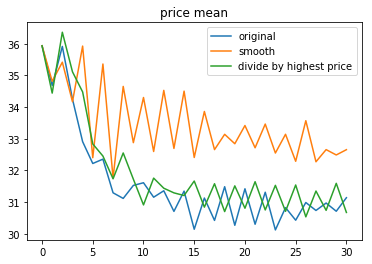

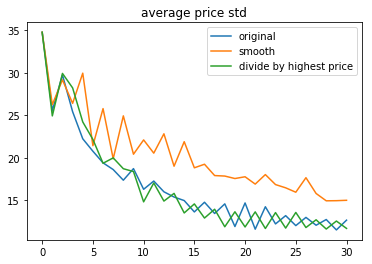

In [17]:
compare_plot(dataframes_usl, dataframe_names, 
             ['price_mean','price_avg_std'],
             ['price mean','average price std'],
            )

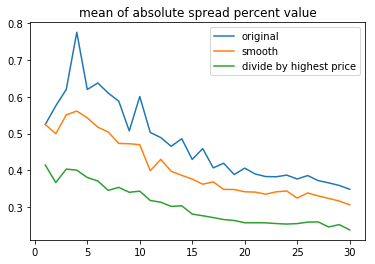

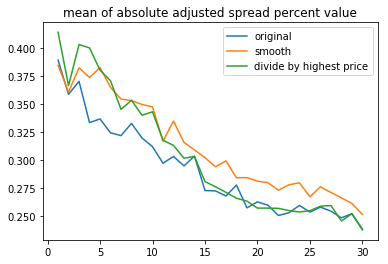

In [18]:
compare_plot(dataframes_usl, 
             dataframe_names, 
             ['abs_spread_pct_mean', 
              'abs_spread_pct_adj_mean'],
             ['mean of absolute spread percent value', 
              'mean of absolute adjusted spread percent value'],
             start_pos=1)

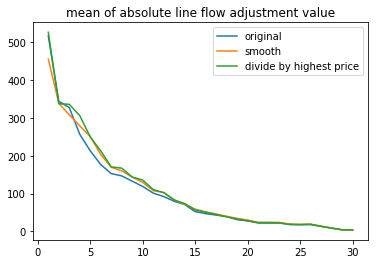

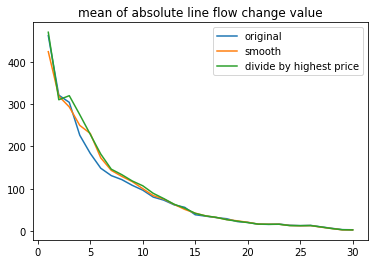

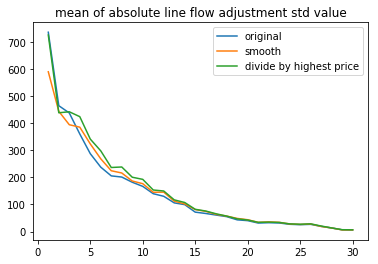

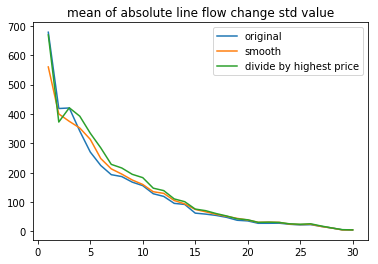

In [19]:
compare_plot(dataframes_usl, 
             dataframe_names, 
             ['abs_line_flow_adj_mean',
              'abs_line_flow_change_mean', 
              'abs_line_flow_adj_avg_std', 
              'abs_line_flow_change_avg_std'],
             ['mean of absolute line flow adjustment value', 
              'mean of absolute line flow change value',
              'mean of absolute line flow adjustment std value', 
              'mean of absolute line flow change std value'],                          
              start_pos=1)